In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("../python") 

import Environment

### Policy Evaluation

In [2]:
def policy_eval(policy, env, discount_factor=1.0, theta=0.01):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    
    Args:
        policy: [S, A] shaped matrix representing the policy.
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
    
    Returns:
        Vector of length env.nS representing the value function.
    """
   
    V = np.zeros(env.nS)     # Start with a random (all 0) value function
    while True:
        delta = 0
        for s in range(env.nS):       # For each state, perform a "full backup"
            v = 0
            for a, action_prob in enumerate(policy[s]):                                     # Look at the possible next actions                
                for  prob, next_state, reward, done in env.P[s][a]:                         # For each action, look at the possible next states...
                    v += action_prob * prob * (reward + discount_factor * V[next_state])    # Calculate the expected value. Ref: Sutton book eq. 4.6.
            delta = max(delta, np.abs(v - V[s]))                                            # How much our value function changed (across any states)
            V[s] = v
            
        if delta < theta:    # Stop evaluating once our value function change is below a threshold
            break

    return np.array(V)

##### Sutton Simple Stochastic World 2 States 2 Actions

In [3]:
env = Environment.Environment("SuttonSimplest")
random_policy = np.ones([env.nS, env.nA]) / env.nA
print("Random Policy Probability Distribution:")
print(random_policy)
print("")
print("Value Function Iterations:")
v = policy_eval(random_policy, env, discount_factor=0.85, theta=0.8)

Setting default max_steps per episode: 5000
Random Policy Probability Distribution:
[[0.5 0.5]
 [0.5 0.5]]

Value Function Iterations:


##### GridWorld Sutton evaluation of random policy

Setting default max_steps per episode: 5000
Reshaped Grid Value Function:
[[ 0.         -5.04409655 -6.81018622 -7.30989047]
 [-5.04409655 -6.35168809 -6.92280952 -6.88129341]
 [-6.81018622 -6.92280952 -6.40858697 -5.13688443]
 [-7.30989047 -6.88129341 -5.13688443  0.        ]]


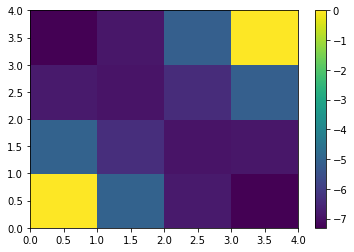

In [4]:
env = Environment.Environment("GridworldSutton")
random_policy = np.ones([env.nS, env.nA]) / env.nA
v = policy_eval(random_policy, env, discount_factor=0.9, theta=0.1)

print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))
plt.pcolor(v.reshape(env.shape))
plt.colorbar()

Setting default max_steps per episode: 5000
Initialized JackCarRental Environment : 10 max_cars 2 max_moving cars
Reshaped Grid Value Function:


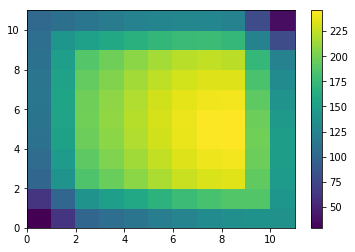

In [5]:
env = Environment.Environment("JackCarRental-10")
random_policy = np.ones([env.nS, env.nA]) / env.nA
v = policy_eval(random_policy, env,  discount_factor=0.9, theta=0.1)

print("Reshaped Grid Value Function:")
plt.pcolor(v.reshape(env.shape))
plt.colorbar()

### Policy Iteration / Improvement

In [6]:
def one_step_lookahead(state, V, env, discount_factor):
    """
    Helper function to calculate the value for all action in a given state.
    Args:  state, V value function vector of length env.nS, env, gamma
    Returns: A vector of length env.nA containing the expected value of each action.
    """
    A = np.zeros(env.nA)
    for a in range(env.nA):
        for prob, next_state, reward, done in env.P[state][a]:
            A[a] += prob * (reward + discount_factor * V[next_state])
    return A

In [7]:
def policy_improvement(env, discount_factor=0.9, theta=0.1):
    """
    Iteratively evaluates and improves a policy until an optimal policy is found.    
    Args: env, discount_factor: gamma discount factor, theta threshold for policy eval
    Returns:
        A tuple (policy, V). 
        policy is the optimal policy, a matrix of shape [S, A] where each state s
        contains a valid probability distribution over actions.
        V is the value function for the optimal policy. 
    """
    policy = np.diag([env.nS, env.nA])          # We cannot start with a random policy (unless we use softmax)
    while True:
        policy_stable = True        
        V = policy_eval(policy, env, discount_factor, theta=theta)     # Evaluate the current policy        
        for s in range(env.nS):
            chosen_a = np.argmax(policy[s])                     
            A = one_step_lookahead(s, V, env, discount_factor)
            best_a = np.argmax(A)            
            if chosen_a != best_a:                                     # Greedily update the policy
                policy_stable = False
            
            policy[s] = np.eye(env.nA)[best_a]
                   
        if policy_stable:                             # If the policy is stable is optimal 
            return policy, V

In [8]:
env = Environment.Environment("SuttonSimplest")
policy, v = policy_improvement(env, discount_factor=0.9, theta=0.1)

print("Policy Probability Distribution:")
print(policy)
print("")

print("Value Function:")
print(v)

Setting default max_steps per episode: 5000
Policy Probability Distribution:
[[0 1]
 [1 0]]

Value Function:
[133.30877223 165.81454066]


/Users/martisanchez/.pyenv/versions/3.7.1/envs/myPy3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in double_scalars
/Users/martisanchez/.pyenv/versions/3.7.1/envs/myPy3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in multiply
/Users/martisanchez/.pyenv/versions/3.7.1/envs/myPy3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars


### Value Iteration

In [9]:
def value_iteration(env, theta=0.0001, discount_factor=1.0):
    """
    Value Iteration Algorithm.   
    Args:
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.        
    Returns:
        A tuple (policy, V) of the optimal policy and the optimal value function.
    """
    V = np.zeros(env.nS)
    while True:        
        delta = 0
        for s in range(env.nS):             # Update each state...   
            A = one_step_lookahead(s, V, env, discount_factor)    # Do a one-step lookahead to find the best action
            best_action_value = np.max(A)
            delta = max(delta, np.abs(best_action_value - V[s]))   # Calculate delta across all states seen so far
            V[s] = best_action_value                               # Update the value function. Ref: Sutton book eq. 4.10. 
         
        if delta < theta:      # Check if we can stop
            break
    
    policy = np.zeros([env.nS, env.nA])  # Create a deterministic policy using the optimal value function 
    for s in range(env.nS):
        A = one_step_lookahead(s, V, env, discount_factor)     # One step lookahead to find the best action for this state
        best_action = np.argmax(A)
        policy[s, best_action] = 1.0     # Always take the best action
    
    return policy, V

##### Sutton Simple Stochastic World 2 States 2 Actions

In [10]:
env = Environment.Environment("SuttonSimplest")
policy, v = value_iteration(env, discount_factor=0.9)

print("Policy Probability Distribution:")
print(policy)
print("")

print("Value Function:")
print(v)

Setting default max_steps per episode: 5000
Policy Probability Distribution:
[[0. 1.]
 [1. 0.]]

Value Function:
[133.76578567 166.23335559]
